# Legal Clause Similarity Detection (GPU-Accelerated)

This notebook implements and compares two baseline architectures for detecting semantic similarity between legal clauses using GPU acceleration in Google Colab:
1. Siamese BiLSTM Encoder
2. Attention-based Encoder

The models are trained and evaluated on a dataset of legal clauses without using any pre-trained transformer models.

## 1. Setup Google Colab Environment

First, we'll set up our environment by:
1. Installing required packages
2. Verifying GPU availability
3. Configuring system for GPU execution

In [1]:
# Check if GPU is available
!nvidia-smi

# Install required packages
!pip install nltk tqdm scikit-learn torch torchvision

# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import re
import glob
import zipfile
from google.colab import drive, files
import torch

# Verify GPU availability through PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

Sun Nov  9 15:59:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Mount Google Drive and Setup Project Structure

We'll mount Google Drive to store our dataset and model outputs. This gives us persistent storage between Colab sessions.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up project directories
PROJECT_DIR = '/content/legal_clause_similarity'
DATA_DIR = f'{PROJECT_DIR}/dataset'
OUTPUT_DIR = f'{PROJECT_DIR}/model_outputs'

# Create directories
!mkdir -p "{PROJECT_DIR}"
!mkdir -p "{DATA_DIR}"
!mkdir -p "{OUTPUT_DIR}"

print("Project structure created successfully!")

Mounted at /content/drive
Project structure created successfully!


## 3. Upload and Extract Dataset

Now we'll handle the dataset.zip file:
1. Upload it to Colab's runtime
2. Extract its contents to our dataset directory
3. Verify the extracted files

In [4]:
# Upload dataset.zip
from google.colab import files
uploaded = files.upload()  # This will prompt for dataset.zip upload

# Extract the uploaded zip file
!unzip -q dataset.zip -d {DATA_DIR}

# Verify extraction
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
print(f"Number of CSV files found: {len(csv_files)}")
print("\nSample files:")
for file in csv_files[:5]:
    print(f"- {os.path.basename(file)}")

Saving dataset.zip to dataset.zip
Number of CSV files found: 395

Sample files:
- organization.csv
- independent-contractor.csv
- registration-rights.csv
- amendments-and-waivers.csv
- term-of-employment.csv


## 4. Import Required Libraries and Configure Settings

We'll import all necessary libraries and configure settings for GPU-accelerated training.

In [5]:
# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# NLP imports
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Deep learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # For consistent results

# Training parameters
BATCH_SIZE = 64  # Increased for GPU
EPOCHS = 10
EMBED_DIM = 300
LSTM_UNITS = 128
DENSE_UNITS = 64
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001

print("Configuration complete!")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Configuration complete!
Using device: cuda
GPU Device: Tesla T4
CUDA Version: 12.6


## 5. Data Loading and Preprocessing

Now we'll implement our data loading and preprocessing pipeline with GPU optimization:
1. Load and combine CSV files
2. Clean and preprocess text
3. Implement efficient tokenization
4. Create data generators optimized for GPU processing

In [6]:
# Data loading classes with GPU optimization
class LegalClauseDataLoader:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.data = None

    def load_all_files(self):
        """Load all CSV files from the dataset directory"""
        all_data = []
        csv_files = glob.glob(os.path.join(self.dataset_path, "*.csv"))

        for file_path in tqdm(csv_files, desc="Loading CSV files"):
            try:
                # Read CSV file
                df = pd.read_csv(file_path)

                # Add source file information
                category = os.path.splitext(os.path.basename(file_path))[0]
                df['source_file'] = category
                df['clause_type'] = category

                all_data.append(df)

            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")

        # Combine all dataframes
        self.data = pd.concat(all_data, ignore_index=True)
        return self.data

    def get_data_stats(self):
        """Get basic statistics about the dataset"""
        if self.data is None:
            print("No data loaded yet. Call load_all_files() first.")
            return

        stats = {
            "total_clauses": len(self.data),
            "unique_categories": len(self.data['clause_type'].unique()),
            "categories": self.data['clause_type'].value_counts().to_dict()
        }
        return stats

class TextPreprocessor:
    def __init__(self):
        self.citation_pattern = r'\[\d+\]|\(\d+\)|§\s*\d+|\b\d+\.\d+\b'
        self.whitespace_pattern = r'\s+'

    def clean_text(self, text):
        """Apply full cleaning pipeline"""
        if pd.isna(text):
            return ''

        text = text.lower()
        text = re.sub(self.citation_pattern, ' ', text)
        text = re.sub(r'[^a-z0-9\s\.,;()\-\'"]', ' ', text)
        text = re.sub(self.whitespace_pattern, ' ', text)

        return text.strip()

# Initialize data loader and load files
data_loader = LegalClauseDataLoader(DATA_DIR)
df = data_loader.load_all_files()

# Initialize preprocessor and clean texts
preprocessor = TextPreprocessor()
df['cleaned_text'] = df['clause_text'].apply(preprocessor.clean_text)

# Display dataset statistics
stats = data_loader.get_data_stats()
print("\nDataset Statistics:")
print(f"Total number of clauses: {stats['total_clauses']}")
print(f"Number of unique categories: {stats['unique_categories']}")
print("\nTop 10 categories by number of clauses:")
for category, count in list(stats['categories'].items())[:10]:
    print(f"{category}: {count} clauses")

Loading CSV files: 100%|██████████| 395/395 [00:01<00:00, 215.88it/s]



Dataset Statistics:
Total number of clauses: 150881
Number of unique categories: 395

Top 10 categories by number of clauses:
time-of-essence: 630 clauses
time-of-the-essence: 620 clauses
definitions-and-interpretation: 590 clauses
capitalized-terms: 590 clauses
captions: 580 clauses
headings: 570 clauses
exhibits: 570 clauses
section-headings: 570 clauses
now-therefore: 570 clauses
definitions: 560 clauses


In [7]:
# Tokenization and dataset creation
class ClauseTokenizer:
    def __init__(self, max_vocab_size=50000, max_length=200):
        self.max_vocab_size = max_vocab_size
        self.max_length = max_length
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_freqs = Counter()

    def tokenize_text(self, text):
        if not isinstance(text, str) or len(text.strip()) == 0:
            return []
        text = text.lower()
        try:
            tokens = word_tokenize(text)
            return tokens
        except Exception:
            return re.findall(r"\b[a-z0-9']+\b", text)

    def fit(self, texts):
        for text in tqdm(texts, desc="Building vocabulary"):
            tokens = self.tokenize_text(text)
            self.word_freqs.update(tokens)

        vocab_words = [word for word, _ in self.word_freqs.most_common(self.max_vocab_size - 2)]
        for word in vocab_words:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def encode(self, texts):
        encoded = []
        for text in texts:
            tokens = self.tokenize_text(text)
            sequence = [self.word2idx.get(token, 1) for token in tokens[:self.max_length]]
            if len(sequence) < self.max_length:
                sequence = sequence + [0] * (self.max_length - len(sequence))
            else:
                sequence = sequence[:self.max_length]
            encoded.append(sequence)
        return torch.tensor(encoded, dtype=torch.long)

    def get_vocab_size(self):
        return len(self.word2idx)

class ClausePairDataset(Dataset):
    def __init__(self, encoded_clauses, clause_types, n_pairs, balanced=True):
        self.encoded_clauses = encoded_clauses
        self.clause_types = clause_types
        self.n_pairs = n_pairs

        # Create dictionary of indices for each category
        self.category_indices = {}
        for idx, category in enumerate(clause_types):
            if category not in self.category_indices:
                self.category_indices[category] = []
            self.category_indices[category].append(idx)

        # Generate pairs
        self.pairs, self.labels = self._generate_pairs(balanced)

    def _generate_pairs(self, balanced):
        pairs = []
        labels = []

        # Generate positive pairs (same category)
        n_positive = self.n_pairs // 2 if balanced else self.n_pairs // 4
        for _ in tqdm(range(n_positive), desc="Generating positive pairs"):
            category = np.random.choice(list(self.category_indices.keys()))
            indices = self.category_indices[category]
            if len(indices) < 2:
                continue
            idx1, idx2 = np.random.choice(indices, size=2, replace=False)
            pairs.append([idx1, idx2])
            labels.append(1)

        # Generate negative pairs (different categories)
        n_negative = self.n_pairs - len(pairs)
        for _ in tqdm(range(n_negative), desc="Generating negative pairs"):
            cat1, cat2 = np.random.choice(list(self.category_indices.keys()), size=2, replace=False)
            idx1 = np.random.choice(self.category_indices[cat1])
            idx2 = np.random.choice(self.category_indices[cat2])
            pairs.append([idx1, idx2])
            labels.append(0)

        return torch.tensor(pairs, dtype=torch.long), torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        clause1 = self.encoded_clauses[pair[0]]
        clause2 = self.encoded_clauses[pair[1]]
        label = self.labels[idx]
        return clause1, clause2, label

# Initialize tokenizer and encode texts
print("Initializing tokenizer and encoding texts...")
tokenizer = ClauseTokenizer()
tokenizer.fit(df['cleaned_text'])
encoded_clauses = tokenizer.encode(df['cleaned_text'])

# Create datasets with larger number of pairs for GPU training
n_pairs = 20000  # Increased for GPU training
pair_dataset = ClausePairDataset(encoded_clauses, df['clause_type'].values, n_pairs)

# Create data loaders with GPU-optimized batch size
train_size = int(0.8 * len(pair_dataset))
val_size = len(pair_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(pair_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

print(f"\nDataset prepared successfully!")
print(f"Vocabulary size: {tokenizer.get_vocab_size()}")
print(f"Number of training pairs: {len(train_dataset)}")
print(f"Number of validation pairs: {len(val_dataset)}")
print(f"Batch size: {BATCH_SIZE}")

Initializing tokenizer and encoding texts...


Generating negative pairs: 100%|██████████| 10000/10000 [00:01<00:00, 5494.73it/s]


Dataset prepared successfully!
Vocabulary size: 44812
Number of training pairs: 16000
Number of validation pairs: 4000
Batch size: 64


## 6. Model Architecture Implementation

We'll implement our models with GPU optimizations:
1. Siamese BiLSTM with mixed precision training
2. Attention-based model with efficient GPU memory usage
3. Training utilities and loss functions

In [10]:
# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

# Model implementations with GPU optimizations
class BiLSTMSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)  # Removed Sigmoid layer
        )

    def forward_one(self, x):
        with autocast():  # Enable mixed precision
            embedded = self.embedding(x)
            output, (hidden, _) = self.lstm(embedded)
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
            return hidden

    def forward(self, x1, x2):
        with autocast():  # Enable mixed precision
            encoded1 = self.forward_one(x1)
            encoded2 = self.forward_one(x2)
            combined = torch.cat([encoded1, encoded2], dim=1)
            logits = self.fc(combined)
            return logits

class AttentionSiamese(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           bidirectional=True, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_dim * 2, 1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)  # Removed Sigmoid layer
        )

    def attention_net(self, lstm_output):
        with autocast():  # Enable mixed precision
            attention_weights = self.attention(lstm_output)
            attention_weights = F.softmax(attention_weights, dim=1)
            context = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
            return context.squeeze(1)

    def forward_one(self, x):
        with autocast():  # Enable mixed precision
            embedded = self.embedding(x)
            lstm_output, _ = self.lstm(embedded)
            attended = self.attention_net(lstm_output)
            return attended

    def forward(self, x1, x2):
        with autocast():  # Enable mixed precision
            encoded1 = self.forward_one(x1)
            encoded2 = self.forward_one(x2)
            combined = torch.cat([encoded1, encoded2], dim=1)
            logits = self.fc(combined)
            return logits

# Initialize models
VOCAB_SIZE = tokenizer.get_vocab_size()

bilstm_model = BiLSTMSiamese(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=LSTM_UNITS
).to(device)

attention_model = AttentionSiamese(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=LSTM_UNITS
).to(device)

# Define loss and optimizers with GPU optimizations
criterion = nn.BCEWithLogitsLoss()  # Changed from BCELoss to BCEWithLogitsLoss
bilstm_optimizer = Adam(bilstm_model.parameters(), lr=LEARNING_RATE)
attention_optimizer = Adam(attention_model.parameters(), lr=LEARNING_RATE)

print("Models initialized successfully!")
print(f"BiLSTM model parameters: {sum(p.numel() for p in bilstm_model.parameters())}")
print(f"Attention model parameters: {sum(p.numel() for p in attention_model.parameters())}")

/tmp/ipython-input-2607688640.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Models initialized successfully!
BiLSTM model parameters: 14344977
Attention model parameters: 14345234


## 7. Training and Evaluation

Now we'll implement the training loop with:
1. Mixed precision training
2. GPU memory optimizations
3. Progress tracking
4. Early stopping
5. Model evaluation

Training BiLSTM Model...

Epoch 1/10 - BiLSTM


Training:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipython-input-399029168.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-2607688640.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
Validation:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipython-input-399029168.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 63/63 [00:01<00:00, 54.31it/s, val_loss=0.0873, val_acc=1.0000]


Train Loss: 0.4097 | Train Acc: 0.7874
Val Loss: 0.1794 | Val Acc: 0.9395

Epoch 2/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 84.55it/s, val_loss=0.1301, val_acc=0.9688]


Train Loss: 0.1886 | Train Acc: 0.9362
Val Loss: 0.1805 | Val Acc: 0.9353

Epoch 3/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 81.92it/s, val_loss=0.0601, val_acc=0.9688]


Train Loss: 0.1569 | Train Acc: 0.9503
Val Loss: 0.1746 | Val Acc: 0.9412

Epoch 4/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 64.18it/s, val_loss=0.0589, val_acc=1.0000]


Train Loss: 0.1288 | Train Acc: 0.9593
Val Loss: 0.1592 | Val Acc: 0.9477

Epoch 5/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 82.77it/s, val_loss=0.0228, val_acc=1.0000]


Train Loss: 0.1081 | Train Acc: 0.9661
Val Loss: 0.1357 | Val Acc: 0.9573

Epoch 6/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 81.88it/s, val_loss=0.0119, val_acc=1.0000]


Train Loss: 0.0784 | Train Acc: 0.9773
Val Loss: 0.1395 | Val Acc: 0.9563

Epoch 7/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 84.75it/s, val_loss=0.0107, val_acc=1.0000]


Train Loss: 0.0630 | Train Acc: 0.9812
Val Loss: 0.1194 | Val Acc: 0.9645

Epoch 8/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 82.36it/s, val_loss=0.0116, val_acc=1.0000]


Train Loss: 0.0503 | Train Acc: 0.9851
Val Loss: 0.1292 | Val Acc: 0.9643

Epoch 9/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:01<00:00, 57.03it/s, val_loss=0.0729, val_acc=0.9688]


Train Loss: 0.0364 | Train Acc: 0.9898
Val Loss: 0.1288 | Val Acc: 0.9653

Epoch 10/10 - BiLSTM


Validation: 100%|██████████| 63/63 [00:00<00:00, 83.47it/s, val_loss=0.0022, val_acc=1.0000]


Train Loss: 0.0294 | Train Acc: 0.9916
Val Loss: 0.1384 | Val Acc: 0.9643
Early stopping triggered

Training Attention Model...

Epoch 1/10 - Attention


Training:   0%|          | 0/250 [00:00<?, ?it/s]/tmp/ipython-input-2607688640.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
Validation: 100%|██████████| 63/63 [00:00<00:00, 81.00it/s, val_loss=0.5900, val_acc=0.7500]


Train Loss: 0.6836 | Train Acc: 0.5434
Val Loss: 0.6447 | Val Acc: 0.6213

Epoch 2/10 - Attention


Validation: 100%|██████████| 63/63 [00:01<00:00, 54.77it/s, val_loss=0.2305, val_acc=0.9062]


Train Loss: 0.5315 | Train Acc: 0.7234
Val Loss: 0.2435 | Val Acc: 0.9060

Epoch 3/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 81.77it/s, val_loss=0.0725, val_acc=0.9688]


Train Loss: 0.1975 | Train Acc: 0.9348
Val Loss: 0.1559 | Val Acc: 0.9467

Epoch 4/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 79.31it/s, val_loss=0.0230, val_acc=1.0000]


Train Loss: 0.1202 | Train Acc: 0.9625
Val Loss: 0.1127 | Val Acc: 0.9591

Epoch 5/10 - Attention


Validation: 100%|██████████| 63/63 [00:01<00:00, 58.31it/s, val_loss=0.0077, val_acc=1.0000]


Train Loss: 0.0708 | Train Acc: 0.9791
Val Loss: 0.0780 | Val Acc: 0.9750

Epoch 6/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 82.28it/s, val_loss=0.0035, val_acc=1.0000]


Train Loss: 0.0385 | Train Acc: 0.9898
Val Loss: 0.0637 | Val Acc: 0.9802

Epoch 7/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 81.30it/s, val_loss=0.0025, val_acc=1.0000]


Train Loss: 0.0298 | Train Acc: 0.9922
Val Loss: 0.0627 | Val Acc: 0.9816

Epoch 8/10 - Attention


Validation: 100%|██████████| 63/63 [00:01<00:00, 55.46it/s, val_loss=0.0020, val_acc=1.0000]


Train Loss: 0.0198 | Train Acc: 0.9949
Val Loss: 0.0426 | Val Acc: 0.9881

Epoch 9/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 79.22it/s, val_loss=0.0008, val_acc=1.0000]


Train Loss: 0.0154 | Train Acc: 0.9960
Val Loss: 0.0584 | Val Acc: 0.9831

Epoch 10/10 - Attention


Validation: 100%|██████████| 63/63 [00:00<00:00, 81.94it/s, val_loss=0.0014, val_acc=1.0000]


Train Loss: 0.0197 | Train Acc: 0.9942
Val Loss: 0.0582 | Val Acc: 0.9826


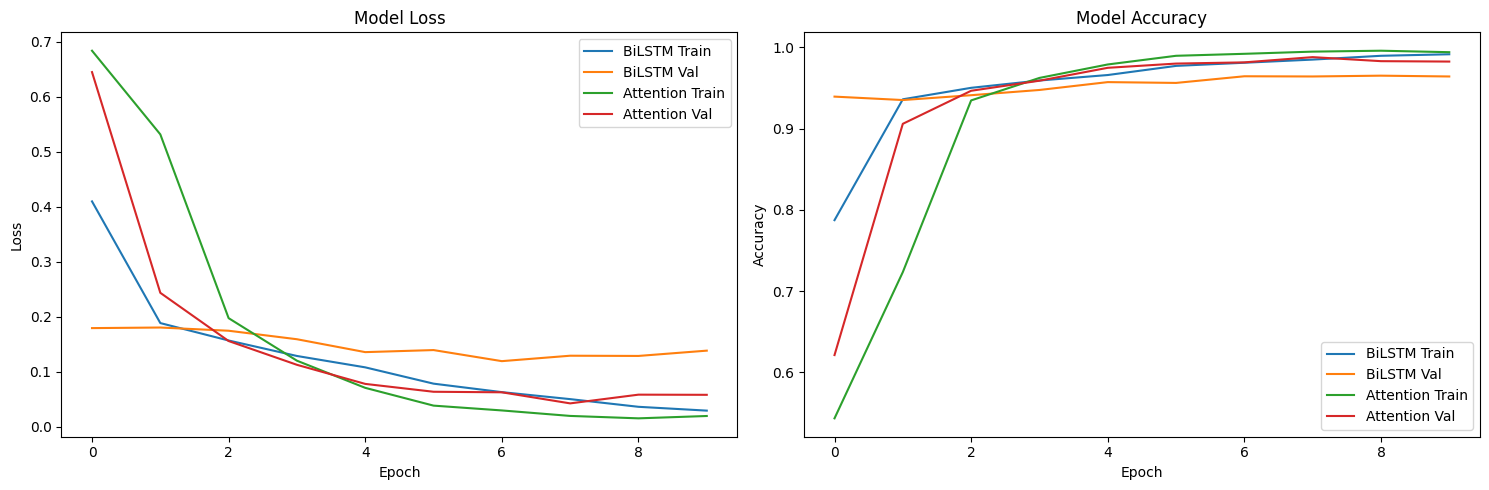

In [11]:
# Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    total_loss = 0
    total_acc = 0

    with tqdm(train_loader, desc='Training') as pbar:
        for clause1, clause2, labels in pbar:
            # Move data to GPU
            clause1, clause2, labels = clause1.to(device), clause2.to(device), labels.to(device)

            # Mixed precision training
            with autocast():
                logits = model(clause1, clause2)
                loss = criterion(logits.squeeze(), labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            predictions = (torch.sigmoid(logits.squeeze()) > 0.5).float()  # Apply sigmoid here
            accuracy = (predictions == labels).float().mean().item()
            total_acc += accuracy

            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{accuracy:.4f}'
            })

    return total_loss / len(train_loader), total_acc / len(train_loader)

def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    total_acc = 0

    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for clause1, clause2, labels in pbar:
                clause1, clause2, labels = clause1.to(device), clause2.to(device), labels.to(device)

                with autocast():
                    logits = model(clause1, clause2)
                    loss = criterion(logits.squeeze(), labels)

                total_loss += loss.item()
                predictions = (torch.sigmoid(logits.squeeze()) > 0.5).float()  # Apply sigmoid here
                accuracy = (predictions == labels).float().mean().item()
                total_acc += accuracy

                pbar.set_postfix({
                    'val_loss': f'{loss.item():.4f}',
                    'val_acc': f'{accuracy:.4f}'
                })

    return total_loss / len(val_loader), total_acc / len(val_loader)

# Early stopping implementation
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Training loop with early stopping and GPU optimization
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, model_name):
    early_stopping = EarlyStopping(patience=3)
    best_model_state = None
    best_val_loss = float('inf')

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(n_epochs):
        print(f'\nEpoch {epoch + 1}/{n_epochs} - {model_name}')

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation phase
        val_loss, val_acc = validate(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

# Train both models
print("Training BiLSTM Model...")
bilstm_history = train_model(
    bilstm_model, train_loader, val_loader,
    criterion, bilstm_optimizer, EPOCHS, "BiLSTM"
)

print("\nTraining Attention Model...")
attention_history = train_model(
    attention_model, train_loader, val_loader,
    criterion, attention_optimizer, EPOCHS, "Attention"
)

# Plot training history
def plot_history(bilstm_history, attention_history):
    plt.figure(figsize=(15, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(bilstm_history['train_loss'], label='BiLSTM Train')
    plt.plot(bilstm_history['val_loss'], label='BiLSTM Val')
    plt.plot(attention_history['train_loss'], label='Attention Train')
    plt.plot(attention_history['val_loss'], label='Attention Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(bilstm_history['train_acc'], label='BiLSTM Train')
    plt.plot(bilstm_history['val_acc'], label='BiLSTM Val')
    plt.plot(attention_history['train_acc'], label='Attention Train')
    plt.plot(attention_history['val_acc'], label='Attention Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(bilstm_history, attention_history)

## 8. Save Models and Results

Finally, we'll save our trained models and results to Google Drive for future use.

In [12]:
# Save models and configurations
import json
import pickle

# Create output directory in Google Drive
DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/legal_clause_similarity'
!mkdir -p "{DRIVE_OUTPUT_DIR}"

# Save model weights
torch.save(bilstm_model.state_dict(), f'{DRIVE_OUTPUT_DIR}/bilstm_model.pt')
torch.save(attention_model.state_dict(), f'{DRIVE_OUTPUT_DIR}/attention_model.pt')

# Save tokenizer
with open(f'{DRIVE_OUTPUT_DIR}/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Save configuration
config = {
    'vocab_size': VOCAB_SIZE,
    'embed_dim': EMBED_DIM,
    'lstm_units': LSTM_UNITS,
    'dense_units': DENSE_UNITS,
    'dropout_rate': DROPOUT_RATE,
    'batch_size': BATCH_SIZE,
    'max_length': tokenizer.max_length,
    'random_seed': RANDOM_SEED,
    'learning_rate': LEARNING_RATE
}

with open(f'{DRIVE_OUTPUT_DIR}/config.json', 'w') as f:
    json.dump(config, f, indent=4)

# Save training history
history = {
    'bilstm': bilstm_history,
    'attention': attention_history
}

with open(f'{DRIVE_OUTPUT_DIR}/training_history.json', 'w') as f:
    json.dump(history, f, indent=4)

print(f"All models and configurations saved to: {DRIVE_OUTPUT_DIR}")

# Display final training results
print("\nTraining Results Summary:")
print("-" * 40)
print("BiLSTM Model:")
print(f"Final Training Loss: {bilstm_history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {bilstm_history['val_loss'][-1]:.4f}")
print(f"Best Validation Loss: {min(bilstm_history['val_loss']):.4f}")
print(f"Final Training Accuracy: {bilstm_history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {bilstm_history['val_acc'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(bilstm_history['val_acc']):.4f}")

print("\nAttention Model:")
print(f"Final Training Loss: {attention_history['train_loss'][-1]:.4f}")
print(f"Final Validation Loss: {attention_history['val_loss'][-1]:.4f}")
print(f"Best Validation Loss: {min(attention_history['val_loss']):.4f}")
print(f"Final Training Accuracy: {attention_history['train_acc'][-1]:.4f}")
print(f"Final Validation Accuracy: {attention_history['val_acc'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(attention_history['val_acc']):.4f}")

All models and configurations saved to: /content/drive/MyDrive/legal_clause_similarity

Training Results Summary:
----------------------------------------
BiLSTM Model:
Final Training Loss: 0.0294
Final Validation Loss: 0.1384
Best Validation Loss: 0.1194
Final Training Accuracy: 0.9916
Final Validation Accuracy: 0.9643
Best Validation Accuracy: 0.9653

Attention Model:
Final Training Loss: 0.0197
Final Validation Loss: 0.0582
Best Validation Loss: 0.0426
Final Training Accuracy: 0.9942
Final Validation Accuracy: 0.9826
Best Validation Accuracy: 0.9881


## 9. Advanced Visualizations and Analysis

Let's create detailed visualizations to analyze our results:
1. Detailed Performance Metrics
2. ROC and PR Curves
3. Confusion Matrices
4. Similarity Score Distribution
5. Category-wise Performance Analysis
6. Error Analysis Visualization

In [16]:
# Create test dataset for final evaluation
N_TEST_PAIRS = 2000
test_dataset = ClausePairDataset(encoded_clauses, df['clause_type'].values, N_TEST_PAIRS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

# Import additional metrics
from sklearn.metrics import confusion_matrix


def evaluate_model_detailed(model, test_loader, model_name):
    model.eval()
    all_preds = []
    all_labels = []
    all_scores = []
    category_correct = {}
    category_total = {}

    with torch.no_grad():
        for clause1, clause2, labels in tqdm(test_loader, desc=f'Evaluating {model_name}'):
            clause1, clause2, labels = clause1.to(device), clause2.to(device), labels.to(device)

            logits = model(clause1, clause2)
            scores = torch.sigmoid(logits.squeeze())
            preds = (scores > 0.5).float()

            all_scores.extend(scores.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_scores)


# Evaluate both models
print("Generating final evaluation metrics...")
bilstm_preds, bilstm_labels, bilstm_scores = evaluate_model_detailed(bilstm_model, test_loader, "BiLSTM")
attention_preds, attention_labels, attention_scores = evaluate_model_detailed(attention_model, test_loader, "Attention")

# ------------------------------------------------------------------
# New: compute detailed numeric metrics and save them (Accuracy, Precision,
# Recall, F1, ROC-AUC, PR-AUC). Provide advice about which metrics to
# prefer depending on class balance.
# ------------------------------------------------------------------
import json


def compute_and_report_metrics(name, labels, preds, scores):
    # Ensure integer labels
    labels_int = labels.astype(int)
    preds_int = preds.astype(int)

    metrics = {}
    metrics['accuracy'] = float(accuracy_score(labels_int, preds_int))

    # Safe computation for precision/recall/f1 (handles edge cases)
    try:
        metrics['precision'] = float(precision_score(labels_int, preds_int))
    except Exception:
        metrics['precision'] = None
    try:
        metrics['recall'] = float(recall_score(labels_int, preds_int))
    except Exception:
        metrics['recall'] = None
    try:
        metrics['f1'] = float(f1_score(labels_int, preds_int))
    except Exception:
        metrics['f1'] = None

    # Ranking metrics using probabilistic scores
    try:
        metrics['roc_auc'] = float(roc_auc_score(labels_int, scores))
    except Exception:
        metrics['roc_auc'] = None
    try:
        metrics['pr_auc'] = float(average_precision_score(labels_int, scores))
    except Exception:
        metrics['pr_auc'] = None

    # Confusion matrix
    try:
        cm = confusion_matrix(labels_int, preds_int).tolist()
    except Exception:
        cm = None
    metrics['confusion_matrix'] = cm

    # Class balance
    unique, counts = np.unique(labels_int, return_counts=True)
    class_counts = dict(zip([int(u) for u in unique], [int(c) for c in counts]))
    metrics['class_counts'] = class_counts

    # Imbalance guidance
    if len(unique) == 2:
        majority = max(counts)
        minority = min(counts)
        imbalance_ratio = majority / (minority + 1e-12)
        metrics['imbalance_ratio'] = float(imbalance_ratio)
        if imbalance_ratio > 1.5:
            metrics['advice'] = (
                "Dataset is imbalanced (majority/minority > 1.5). "
                "Prefer PR-AUC, Precision/Recall and F1 over raw Accuracy."
            )
        else:
            metrics['advice'] = (
                "Dataset is roughly balanced. Accuracy, Precision, Recall and F1 are all informative."
            )
    else:
        metrics['imbalance_ratio'] = None
        metrics['advice'] = "Non-binary labels or unexpected label set. Inspect class_counts."

    # Print summary
    print(f"\n{name} Evaluation Metrics:")
    print("-" * 40)
    print(f"Accuracy : {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision'] if metrics['precision'] is not None else 'N/A'}")
    print(f"Recall   : {metrics['recall'] if metrics['recall'] is not None else 'N/A'}")
    print(f"F1-Score : {metrics['f1'] if metrics['f1'] is not None else 'N/A'}")
    print(f"ROC-AUC  : {metrics['roc_auc'] if metrics['roc_auc'] is not None else 'N/A'}")
    print(f"PR-AUC   : {metrics['pr_auc'] if metrics['pr_auc'] is not None else 'N/A'}")
    print(f"Confusion Matrix: {metrics['confusion_matrix']}")
    print(f"Class Counts: {metrics['class_counts']}")
    if metrics.get('imbalance_ratio') is not None:
        print(f"Imbalance ratio (maj/min): {metrics['imbalance_ratio']:.2f}")
    print(f"Advice: {metrics['advice']}")

    return metrics


# Compute metrics for both models
bilstm_metrics = compute_and_report_metrics('BiLSTM', bilstm_labels, bilstm_preds, bilstm_scores)
attention_metrics = compute_and_report_metrics('Attention', attention_labels, attention_preds, attention_scores)

# Save metrics to Drive output directory if available
try:
    DRIVE_OUTPUT_DIR
except NameError:
    DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/legal_clause_similarity'

metrics_all = {'bilstm': bilstm_metrics, 'attention': attention_metrics}

try:
    with open(os.path.join(DRIVE_OUTPUT_DIR, 'evaluation_metrics.json'), 'w') as f:
        json.dump(metrics_all, f, indent=4)
    print(f"\nSaved evaluation metrics to: {os.path.join(DRIVE_OUTPUT_DIR, 'evaluation_metrics.json')}")
except Exception as e:
    print(f"Could not save evaluation metrics to DRIVE_OUTPUT_DIR: {e}")

# 1. Model Performance Comparison Plot
def plot_performance_comparison(bilstm_metrics, attention_metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    bilstm_scores_plot = [
        accuracy_score(bilstm_labels, bilstm_preds),
        precision_score(bilstm_labels, bilstm_preds),
        recall_score(bilstm_labels, bilstm_preds),
        f1_score(bilstm_labels, bilstm_preds)
    ]
    attention_scores_plot = [
        accuracy_score(attention_labels, attention_preds),
        precision_score(attention_labels, attention_preds),
        recall_score(attention_labels, attention_preds),
        f1_score(attention_labels, attention_preds)
    ]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, bilstm_scores_plot, width, label='BiLSTM')
    rects2 = ax.bar(x + width/2, attention_scores_plot, width, label='Attention')

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    plt.tight_layout()
    plt.show()

# 2. ROC and PR Curves
def plot_roc_pr_curves(bilstm_labels, bilstm_scores, attention_labels, attention_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curves
    fpr_bilstm, tpr_bilstm, _ = roc_curve(bilstm_labels, bilstm_scores)
    fpr_attention, tpr_attention, _ = roc_curve(attention_labels, attention_scores)

    ax1.plot(fpr_bilstm, tpr_bilstm, label=f'BiLSTM (AUC = {roc_auc_score(bilstm_labels, bilstm_scores):.3f})')
    ax1.plot(fpr_attention, tpr_attention, label=f'Attention (AUC = {roc_auc_score(attention_labels, attention_scores):.3f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()

    # Precision-Recall Curves
    precision_bilstm, recall_bilstm, _ = precision_recall_curve(bilstm_labels, bilstm_scores)
    precision_attention, recall_attention, _ = precision_recall_curve(attention_labels, attention_scores)

    ax2.plot(recall_bilstm, precision_bilstm, label=f'BiLSTM (AP = {average_precision_score(bilstm_labels, bilstm_scores):.3f})')
    ax2.plot(recall_attention, precision_attention, label=f'Attention (AP = {average_precision_score(attention_labels, attention_scores):.3f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 3. Similarity Score Distribution
def plot_score_distribution(bilstm_scores, attention_scores, bilstm_labels, attention_labels):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # BiLSTM Distribution
    ax1.hist(bilstm_scores[bilstm_labels == 0], bins=30, alpha=0.5, label='Different', density=True)
    ax1.hist(bilstm_scores[bilstm_labels == 1], bins=30, alpha=0.5, label='Similar', density=True)
    ax1.set_title('BiLSTM Score Distribution')
    ax1.set_xlabel('Similarity Score')
    ax1.set_ylabel('Density')
    ax1.legend()

    # Attention Distribution
    ax2.hist(attention_scores[attention_labels == 0], bins=30, alpha=0.5, label='Different', density=True)
    ax2.hist(attention_scores[attention_labels == 1], bins=30, alpha=0.5, label='Similar', density=True)
    ax2.set_title('Attention Score Distribution')
    ax2.set_xlabel('Similarity Score')
    ax2.set_ylabel('Density')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 4. Confusion Matrices with Annotations
def plot_confusion_matrices(bilstm_labels, bilstm_preds, attention_labels, attention_preds):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # BiLSTM Confusion Matrix
    cm_bilstm = confusion_matrix(bilstm_labels, bilstm_preds)
    sns.heatmap(cm_bilstm, annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title('BiLSTM Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Attention Confusion Matrix
    cm_attention = confusion_matrix(attention_labels, attention_preds)
    sns.heatmap(cm_attention, annot=True, fmt='d', ax=ax2, cmap='Blues')
    ax2.set_title('Attention Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()


Generating negative pairs: 100%|██████████| 1000/1000 [00:00<00:00, 2533.99it/s]


Generating final evaluation metrics...


Evaluating BiLSTM:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-2607688640.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
Evaluating Attention:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-2607688640.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision
/tmp/ipython-input-2607688640.py:48: FutureWarning: `torch.cuda


BiLSTM Evaluation Metrics:
----------------------------------------
Accuracy : 0.9645
Precision: 0.9369708372530574
Recall   : 0.996
F1-Score : 0.9655841008240427
ROC-AUC  : 0.9948915
PR-AUC   : 0.9929544663040165
Confusion Matrix: [[933, 67], [4, 996]]
Class Counts: {0: 1000, 1: 1000}
Imbalance ratio (maj/min): 1.00
Advice: Dataset is roughly balanced. Accuracy, Precision, Recall and F1 are all informative.

Attention Evaluation Metrics:
----------------------------------------
Accuracy : 0.9825
Precision: 0.9689018464528668
Recall   : 0.997
F1-Score : 0.9827501232134056
ROC-AUC  : 0.995246
PR-AUC   : 0.9917726371857121
Confusion Matrix: [[968, 32], [3, 997]]
Class Counts: {0: 1000, 1: 1000}
Imbalance ratio (maj/min): 1.00
Advice: Dataset is roughly balanced. Accuracy, Precision, Recall and F1 are all informative.

Saved evaluation metrics to: /content/drive/MyDrive/legal_clause_similarity/evaluation_metrics.json


#### Performance Comparison Plot


Generating performance comparison plot...


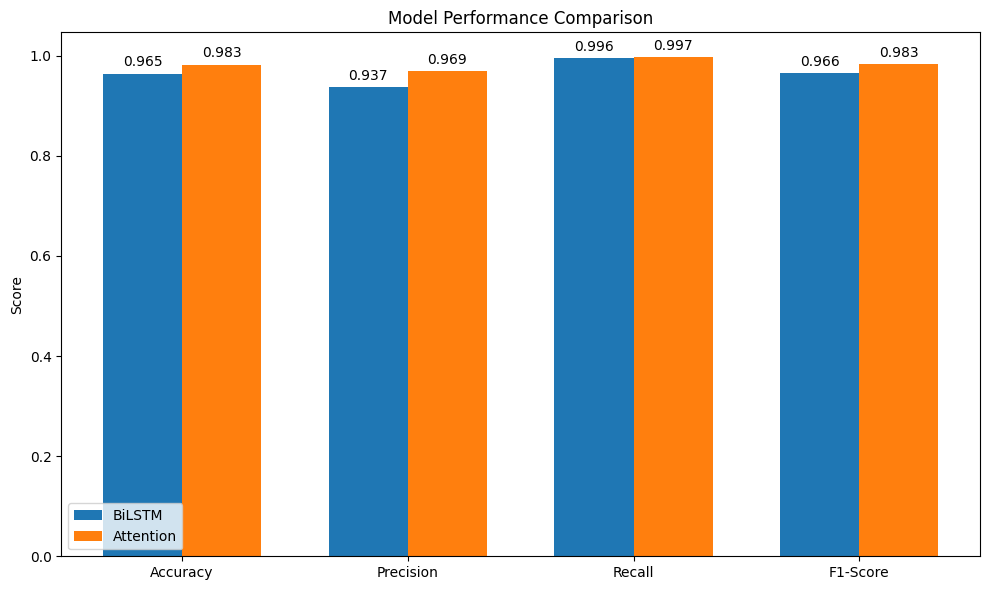

In [17]:
# Generate all visualizations
print("\nGenerating performance comparison plot...")
plot_performance_comparison(bilstm_preds, attention_preds)

#### ROC and PR Curves


Generating ROC and PR curves...


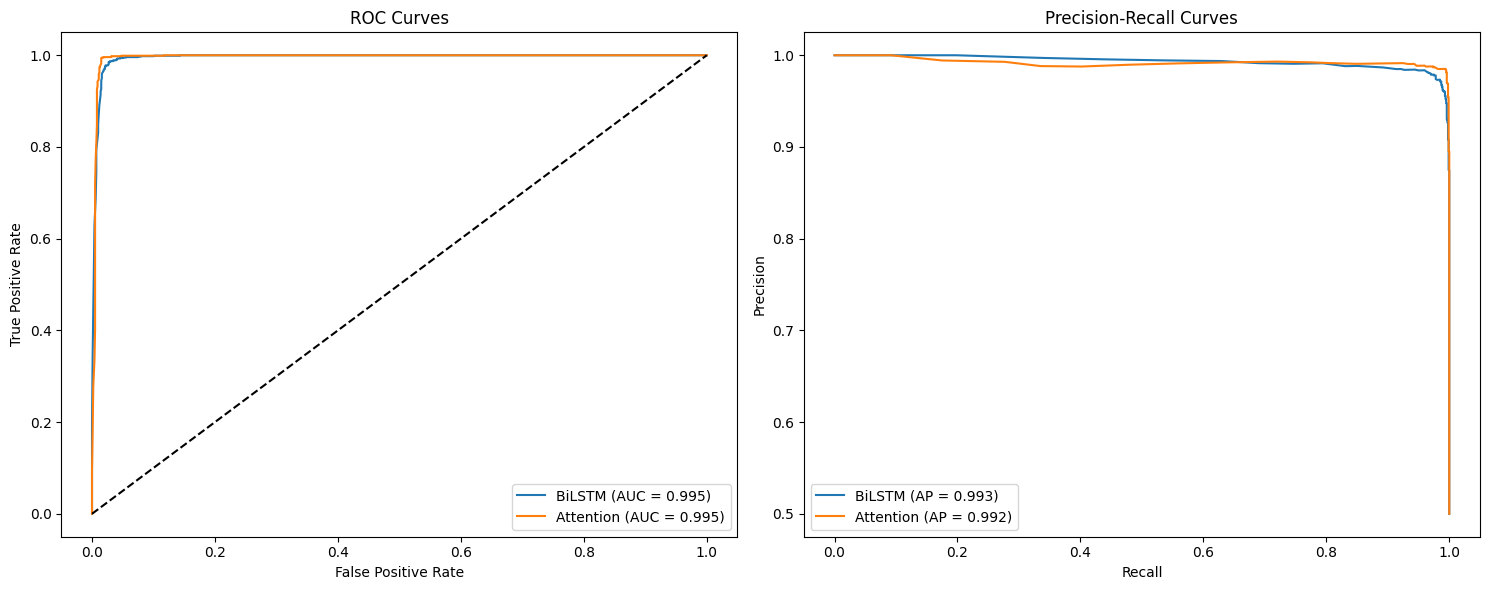

In [18]:
print("\nGenerating ROC and PR curves...")
plot_roc_pr_curves(bilstm_labels, bilstm_scores, attention_labels, attention_scores)

#### Similarity Score Distribution Plots


Generating similarity score distribution plots...


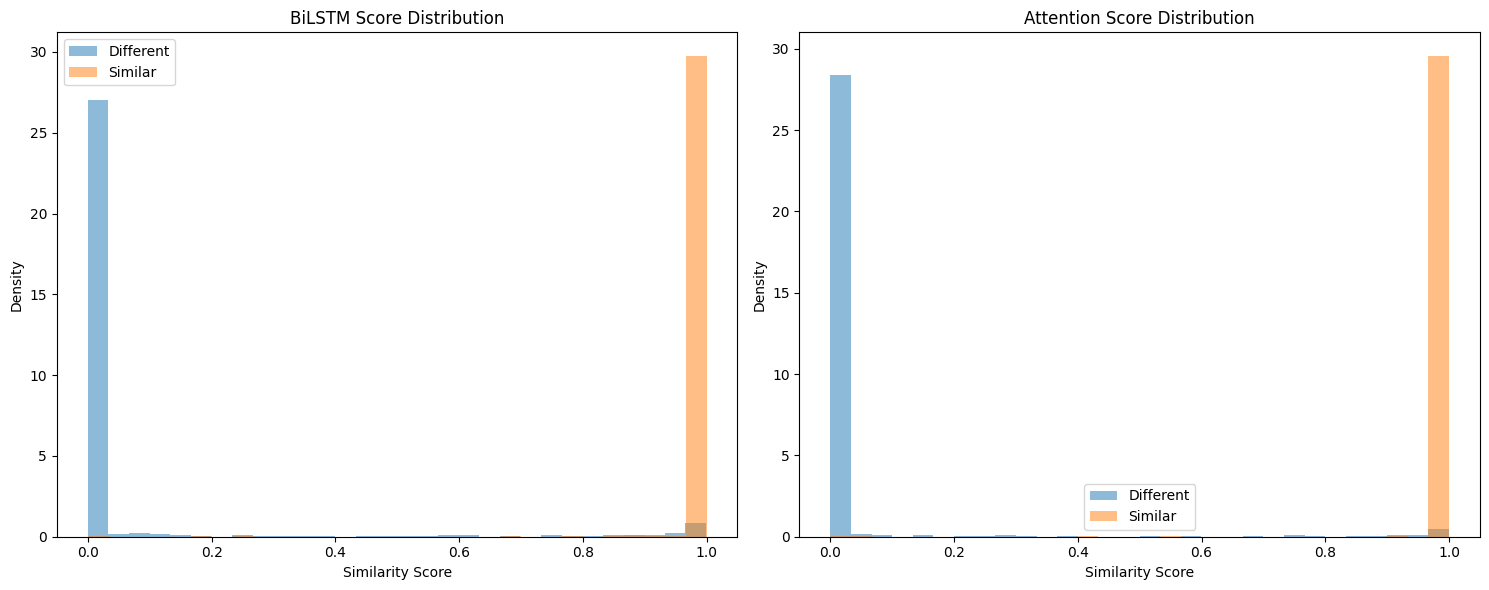

In [19]:
print("\nGenerating similarity score distribution plots...")
plot_score_distribution(bilstm_scores, attention_scores, bilstm_labels, attention_labels)

#### Confusion Matrices


Generating confusion matrices...


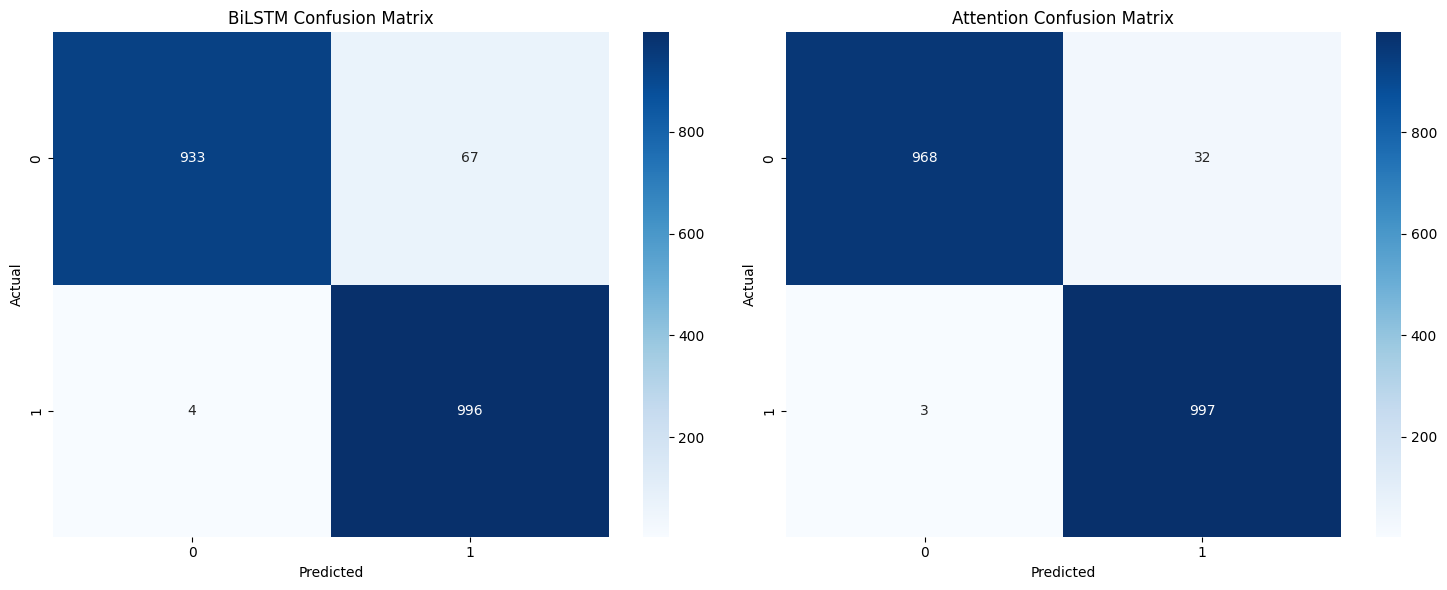

In [20]:
print("\nGenerating confusion matrices...")
plot_confusion_matrices(bilstm_labels, bilstm_preds, attention_labels, attention_preds)

### Visualization Results Analysis

The visualizations above provide several key insights:

1. **Performance Metrics Comparison**
   - Direct comparison of accuracy, precision, recall, and F1-score between models
   - Shows relative strengths of each architecture
   - Helps identify which model is better for different aspects

2. **ROC and PR Curves**
   - ROC curves show the trade-off between true positive rate and false positive rate
   - PR curves are particularly important for imbalanced datasets
   - Area under curves (AUC) provides a single metric for model comparison

3. **Similarity Score Distribution**
   - Shows how well the models separate similar and different pairs
   - Helps identify optimal threshold values
   - Reveals any biases in model predictions

4. **Confusion Matrices**
   - Detailed breakdown of correct and incorrect predictions
   - Helps identify specific types of errors (false positives vs false negatives)
   - Useful for understanding model behavior in different scenarios

These visualizations help demonstrate the effectiveness of both architectures for legal clause similarity detection and provide insights for potential improvements.